# 1. Train validation test procedure

`Model` class which used to create, train, validate, and save a model aiming to identify pneumonia chest x-ray.

Our first goal in this step is to elaborate a methodology allowing us to split our dataset between training, validation and testing.


First, we need to import some packages and custom modules.

The `__init__` method initializes the class by creating training and validation `Dataset` objects.

These datasets are then built using TensorFlow's `AUTOTUNE` functionality for optimized data loading.

Various information about the data, such as the class names and batch shapes, is then printed out.


In [ ]:
import os
import pathlib
import sys

import matplotlib.pyplot as plt
import tensorflow as tf
from dotenv import load_dotenv

PROJECT_ROOT = os.path.abspath(os.path.join(os.path.dirname(__file__), os.pardir))
sys.path.append(PROJECT_ROOT)

from utils.x_ray_data_viz import plot_history
from utils.x_ray_dataset_builder import Dataset

MODEL_ID = os.getenv("MODEL_ID")
CHARTS_DIR = pathlib.Path(os.getenv(f"MODEL_{MODEL_ID}_CHART_DIR")).absolute()
MODELS_DIR = pathlib.Path(os.getenv(f"MODEL_{MODEL_ID}_MODEL_DIR")).absolute()


class Model:
        def __init__(
        self,
        batch_size: int,
        img_size: int,
        img_color: str,
        label_mode: str,
        interactive_reports: bool = True,
    ):
        train_dir = pathlib.Path("data/train")

        train_ds = Dataset(
            train_dir,
            batch_size=batch_size,
            color_mode=img_color,
            image_size=img_size,
            label_mode=label_mode,
            subset="training",
            validation_split=0.2,
        )

        val_ds = Dataset(
            train_dir,
            batch_size=batch_size,
            color_mode=img_color,
            image_size=img_size,
            label_mode=label_mode,
            subset="validation",
            validation_split=0.2,
        )

        AUTOTUNE = tf.data.AUTOTUNE

        train_ds.build(AUTOTUNE, True)

        val_ds.build(AUTOTUNE)

        class_names = train_ds.get_class_names()
        print("\nClass names:")
        print(class_names)

        train_x_batch_shape = train_ds.get_x_batch_shape()
        print("\nTraining dataset's images batch shape is:")
        print(train_x_batch_shape)

        train_y_batch_shape = train_ds.get_y_batch_shape()
        print("\nTraining dataset's labels batch shape is:")
        print(train_y_batch_shape)

        train_ds.display_images_in_batch(
            2,
            "Training dataset",
            CHARTS_DIR.joinpath("dataset/train_dataset_image_sample.png"),
            interactive=interactive_reports,
        )
        train_ds.display_batch_number(
            "Training dataset",
            CHARTS_DIR.joinpath("dataset/train_dataset_batch_number.png"),
            interactive=interactive_reports,
        )
        train_ds.display_distribution(
            "Training dataset",
            CHARTS_DIR.joinpath("dataset/train_dataset_image_distribution.png"),
            interactive=interactive_reports,
        )
        train_ds.display_mean(
            "Training dataset",
            CHARTS_DIR.joinpath("dataset/train_dataset_image_mean.png"),
            interactive=interactive_reports,
        )

        val_x_batch_shape = train_ds.get_x_batch_shape()
        print("\nValidation dataset's images batch shape is:")
        print(val_x_batch_shape)

        val_y_batch_shape = train_ds.get_y_batch_shape()
        print("\nValidation dataset's labels batch shape is:")
        print(val_y_batch_shape)

        val_ds.display_images_in_batch(
            2,
            "Validation dataset",
            CHARTS_DIR.joinpath("dataset/test_dataset_image_sample.png"),
            interactive=interactive_reports,
        )
        val_ds.display_batch_number(
            "Validation dataset",
            CHARTS_DIR.joinpath("dataset/test_dataset_batch_number.png"),
            interactive=interactive_reports,
        )
        val_ds.display_distribution(
            "Validation dataset",
            CHARTS_DIR.joinpath("dataset/test_dataset_image_distribution.png"),
            interactive=interactive_reports,
        )
        val_ds.display_mean(
            "Validation dataset",
            CHARTS_DIR.joinpath("dataset/test_dataset_image_mean.png"),
            interactive=interactive_reports,
        )

        self.batch_size = batch_size
        self.class_names = class_names
        self.img_color = img_color
        self.img_size = img_size
        self.interactive_reports = interactive_reports
        self.train_ds = train_ds.normalized_dataset
        self.val_ds = val_ds.normalized_dataset


The `build` method defines and compiles the model.

The model is a simple feed-forward neural network (also known as a multi-layer perceptron or MLP) with one hidden layer of 128 neurons. The goal is not to build a model for performances but to implement a first train, validation, test procedure.

The input data are flattened before being passed through the network.

The output layer uses a softmax activation function, which is standard for multi-class classification problems.

The model is compiled with the Adam optimizer and categorical cross-entropy loss, which is also standard for such tasks.

Four metrics are monitored during training: categorical accuracy, precision, recall, and AUC (Area Under the ROC Curve).


In [ ]:
    def build(self):
        channels = 1 if self.img_color == "grayscale" else 3

        model = tf.keras.Sequential(
            [
                tf.keras.layers.Flatten(
                    input_shape=(self.img_size, self.img_size, channels)
                ),
                tf.keras.layers.Dense(128, activation="relu"),
                tf.keras.layers.Dense(1, activation="sigmoid"),
            ]
        )

        model.compile(
            optimizer="adam",
            loss="binary_crossentropy",
            metrics=[
                tf.keras.metrics.BinaryAccuracy(),
                tf.keras.metrics.Precision(),
                tf.keras.metrics.Recall(),
            ],
        )

        model.summary()

        return model

The `train` method trains the model for a specified number of epochs.

The model's accuracy and loss on both the training and validation data are plotted after each epoch.

This allows for the monitoring of the model's performance over time and the detection of any overfitting (where the model performs well on the training data but poorly on the validation data).

After training, the model is saved in both Keras' native format and in a format compatible with TensorFlow.js, which enables the model to be used in a web browser.


In [ ]:
def train(self, epochs):
        model = self.build()

        print("\nStarting training...")

        history = model.fit(
            self.train_ds,
            batch_size=self.batch_size,
            epochs=epochs,
            validation_data=self.val_ds,
        )

        print("\n\033[92mTraining done !\033[0m")

        plot_history(
            history,
            CHARTS_DIR.joinpath("training_metrics/training_loss_and_accuracy.png"),
            accuracy_metric="categorical_accuracy",
            interactive=self.interactive_reports,
        )

        print("\nSaving model...")

        model.save(MODELS_DIR.joinpath("model_1.keras"))

        print("\n\033[92mSaving done !\033[0m")

In summary, this code provides a full procedure for training a machine learning model, including data loading, model creation, training, validation, and saving.

The procedure is specific to a binary classification task, but could be adapted for other types of tasks.

The use of a validation dataset allows for the monitoring of the model's performance on unseen data during training, which can help prevent overfitting.
This dataset is build as a subset of the data/train directory. Idem for the training dataset. For the test datasets, it's accessed only during evaluation phase.
This allow us to detect overfiting or bad performances and correspond to the principe of the train, validation, test procedure.


### Run the code

Go into your .env file and set : 
- `TRAINING_MODE`: 1 or 0 (This will tell our main script to train the model instead of run it)
- `MODEL_ID`: 1 or 0 (This is your model step id. We are in the step 1_train_validation_test_procedure so it's 1)
- `INTERACTIVE_SESSION`: 1 or 0 (Show and save metrics, graphics if 1 else only save the files)

The only other parameters that you have to change if you wan't to re-train your model are :

- `MODEL_1_BATCH_SIZE`: in how many batch your values will be reparted
- `MODEL_1_CLASS_TYPE`: if you want to try categoricall classification (Don't use it we only have two class binary is ok)
- `MODEL_1_EPOCHS`: how many time your model will on every batch
- `MODEL_1_IMG_COLOR` either grayscale or rgb. Color don't matter so save computation power
- `MODEL_1_IMG_SIZE`: the size in pixel that your images will be resized

- `MODEL_1_CHART_DIR`: where to save charts file
- `MODEL_1_EVAL_LOG_FILE`: where to save logs files during inference
- `MODEL_1_MODEL_DIR`: where to save the models to evaluate or infer
- `MODEL_1_TRAIN_LOG`_FILE: where to save logs files during training (very usefull to retrieve cross validation results)
- `MODEL_1_WEB_DIR`: where to save the model.json that will allow us to infer in the browser if wanted

### Training and testing datasets infos

#### Batch repartition

Regarding the size of the dataset we might be encounter some overfiting issue. So the first next step we'll be to cope with that.

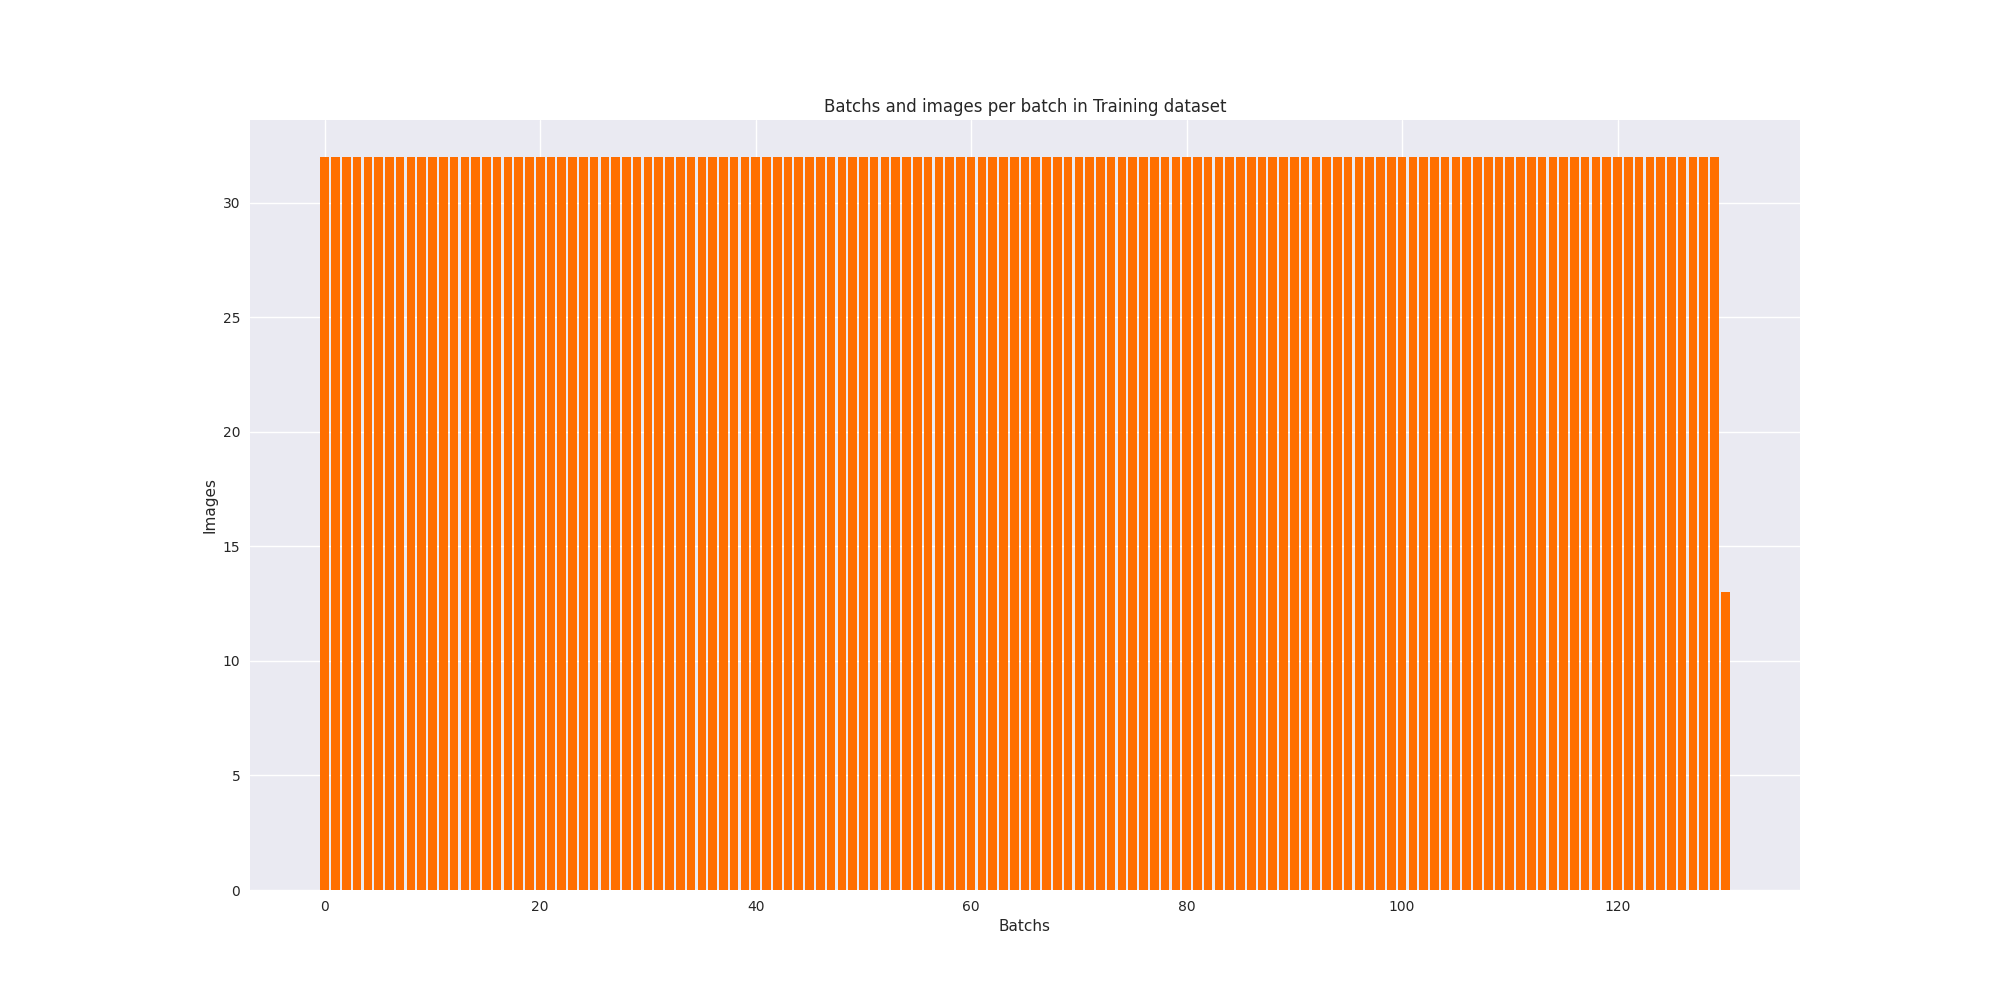
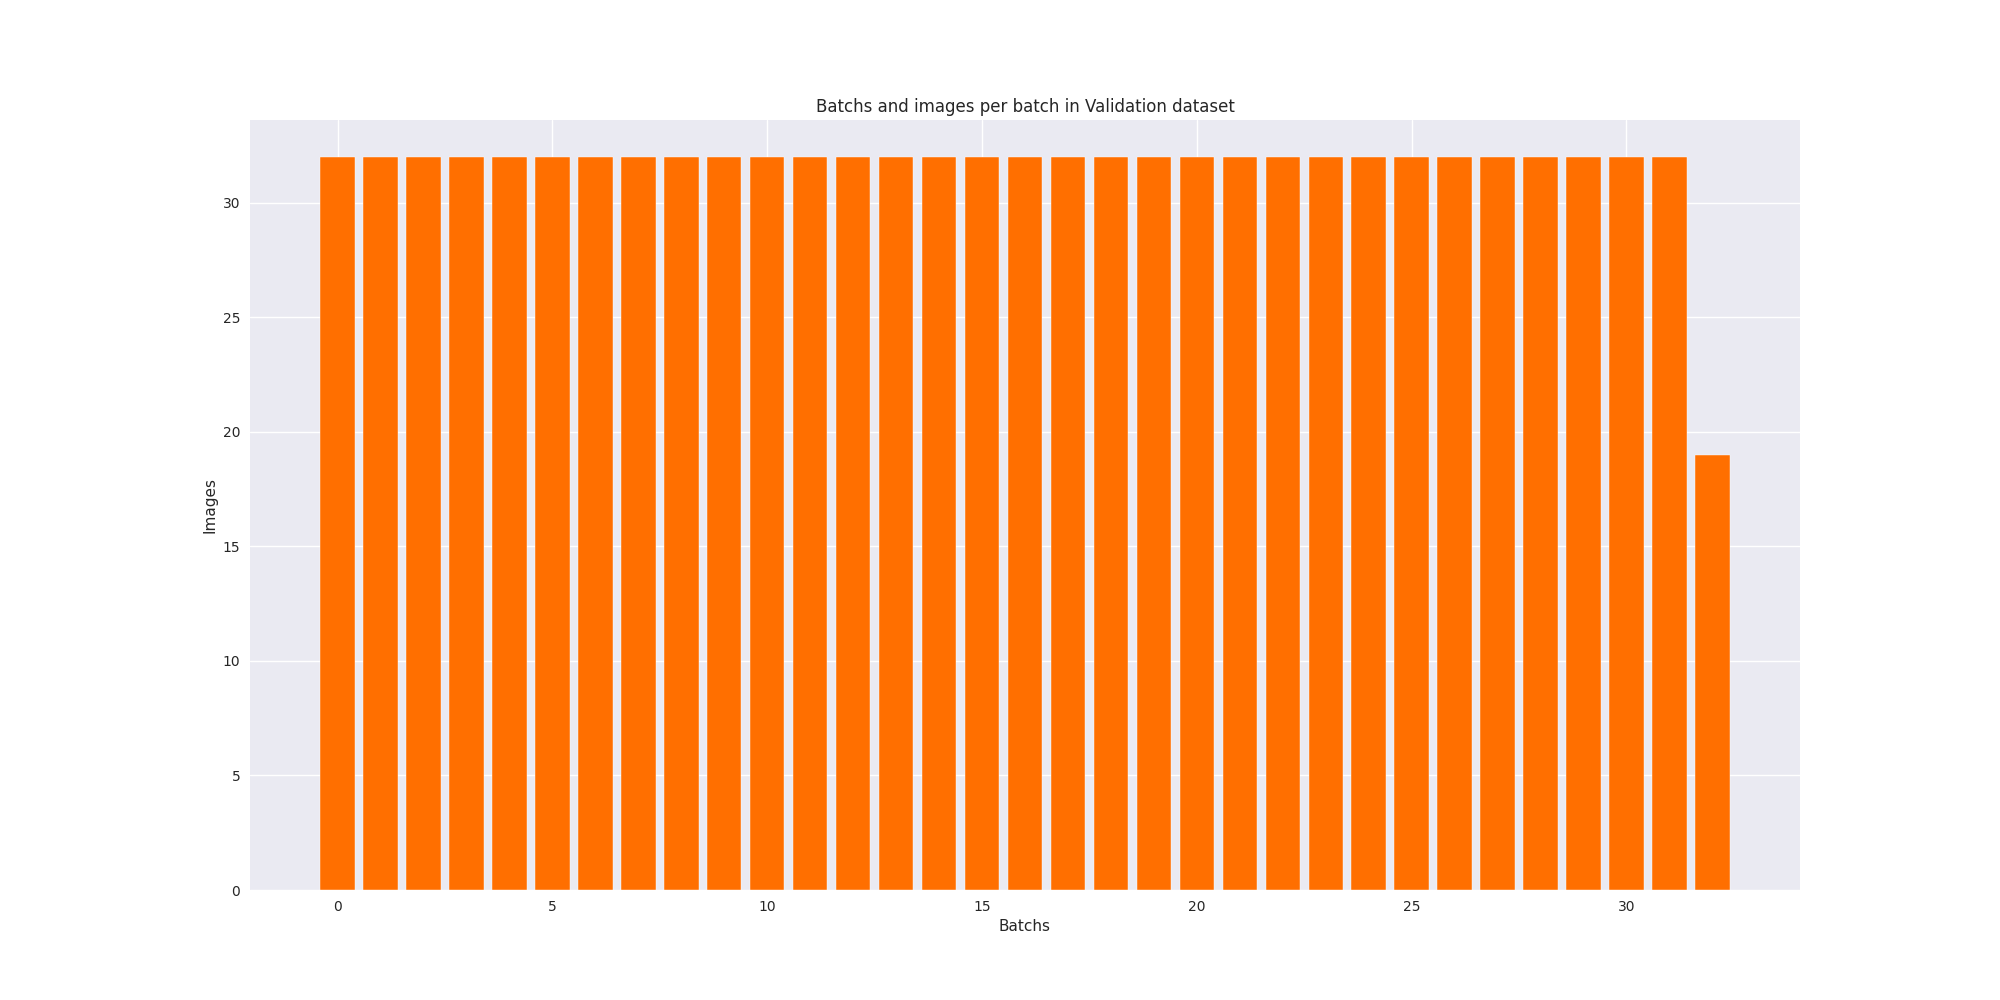

#### Images samples

Here you can see how the images looks. It can be common sense to presume that colors will not play a crucial role in image identification.

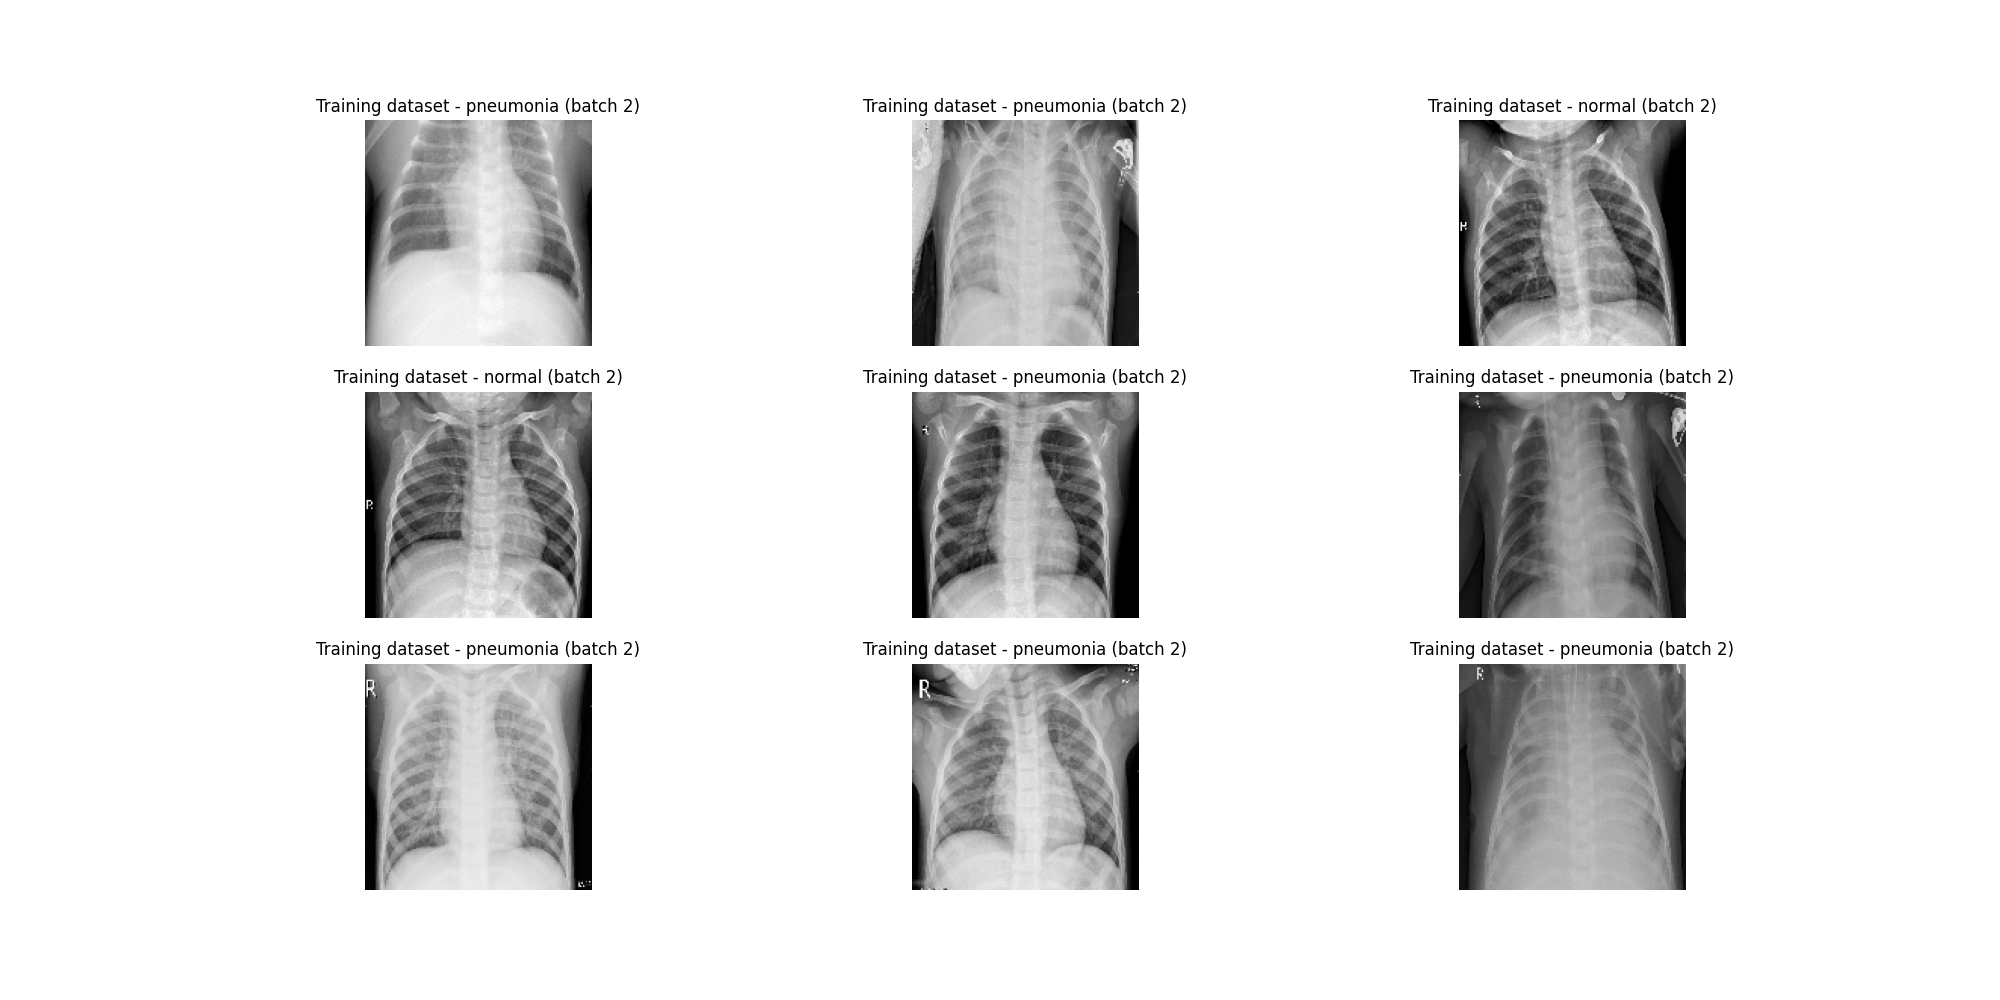
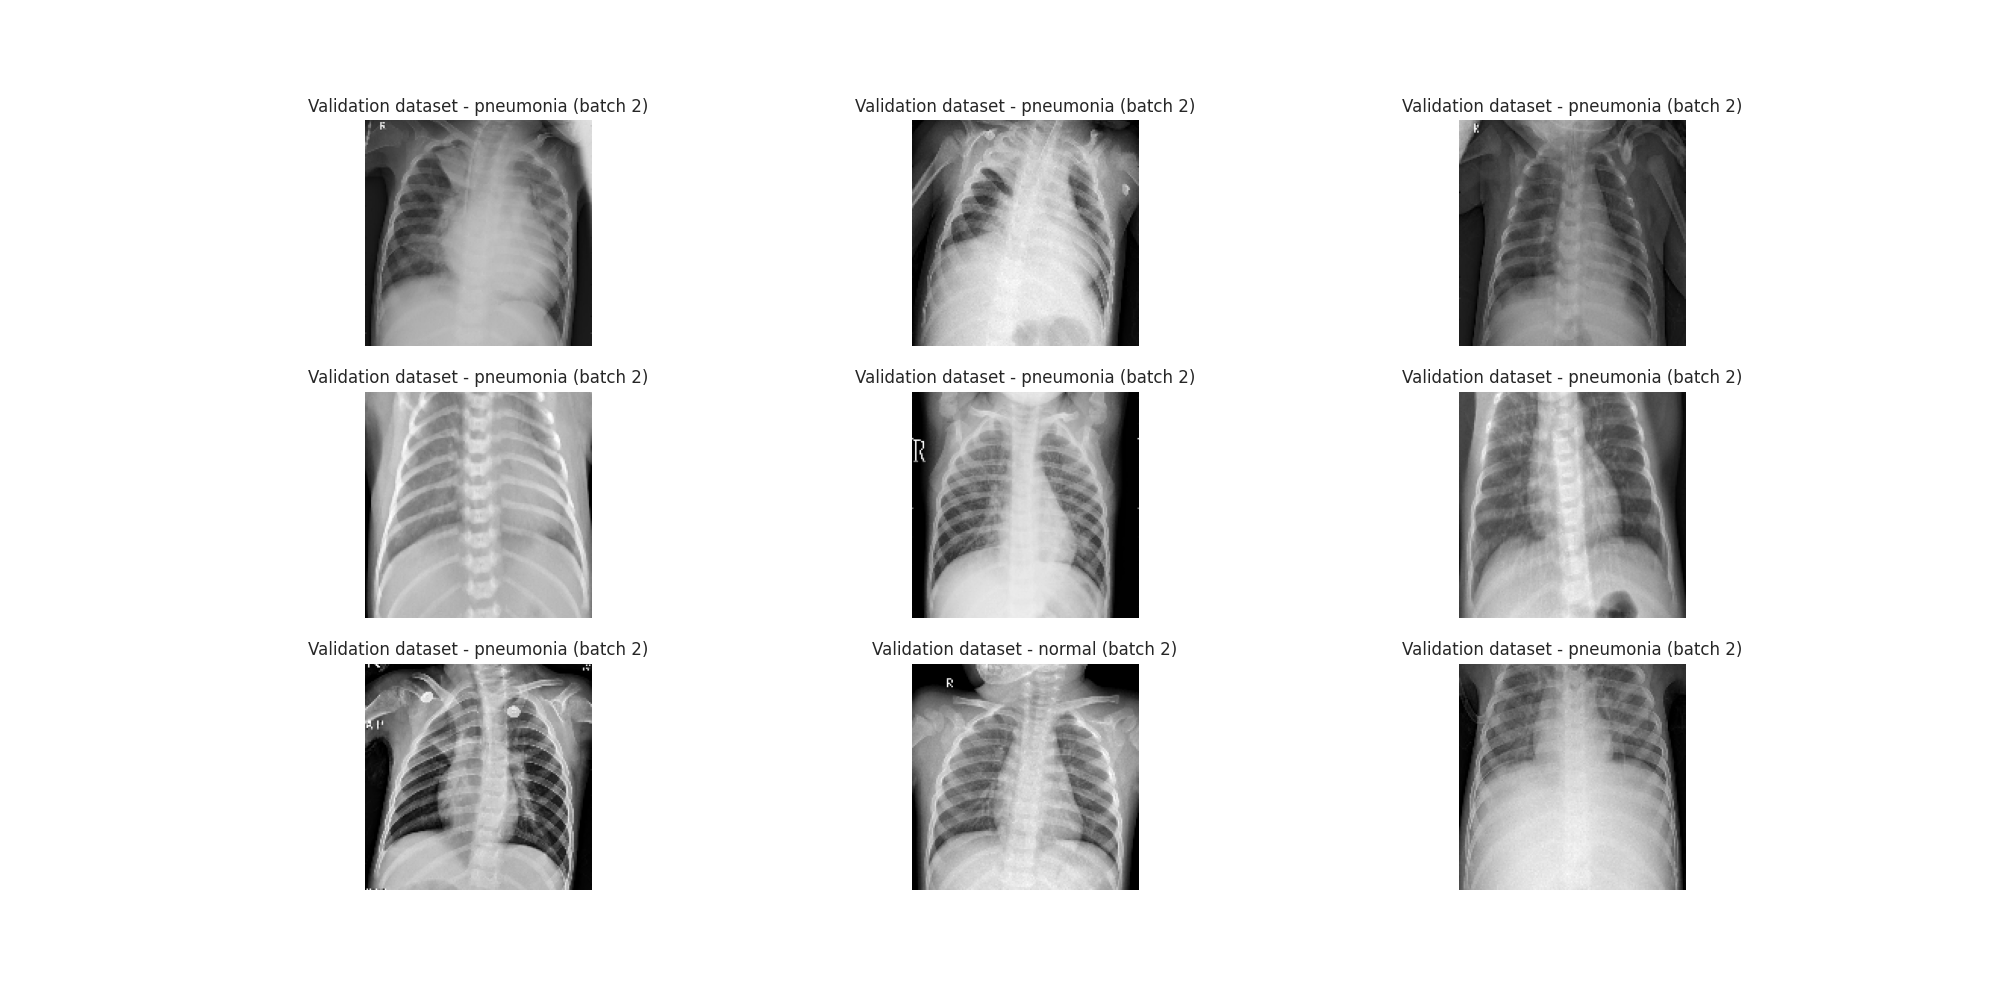

#### Mean and distribution

We can already see that there is a severe class imbalenced issue by looking at the distribution. We'll deal with that in step 5 regularization.
Cross validation can also help by compare a k fold of the dataset as training against the rest as validation data. But we'll see that in more details next step ! 

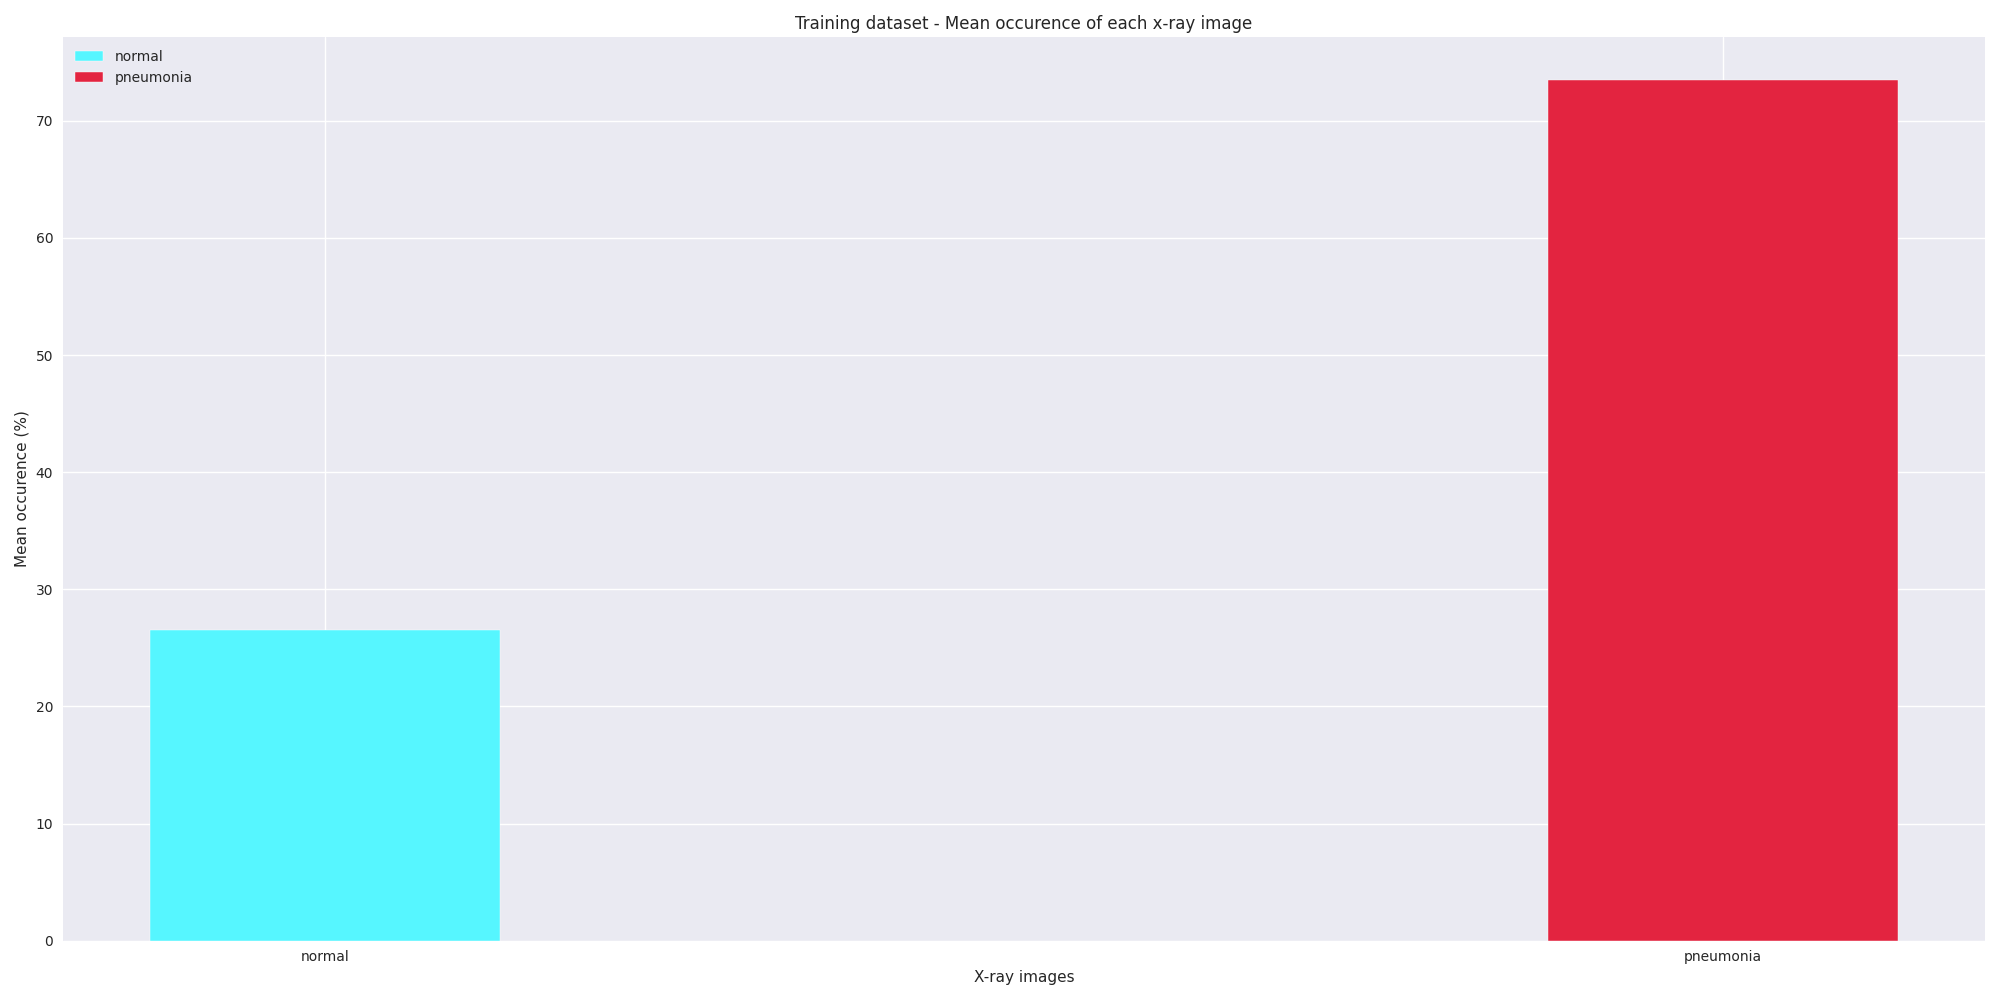
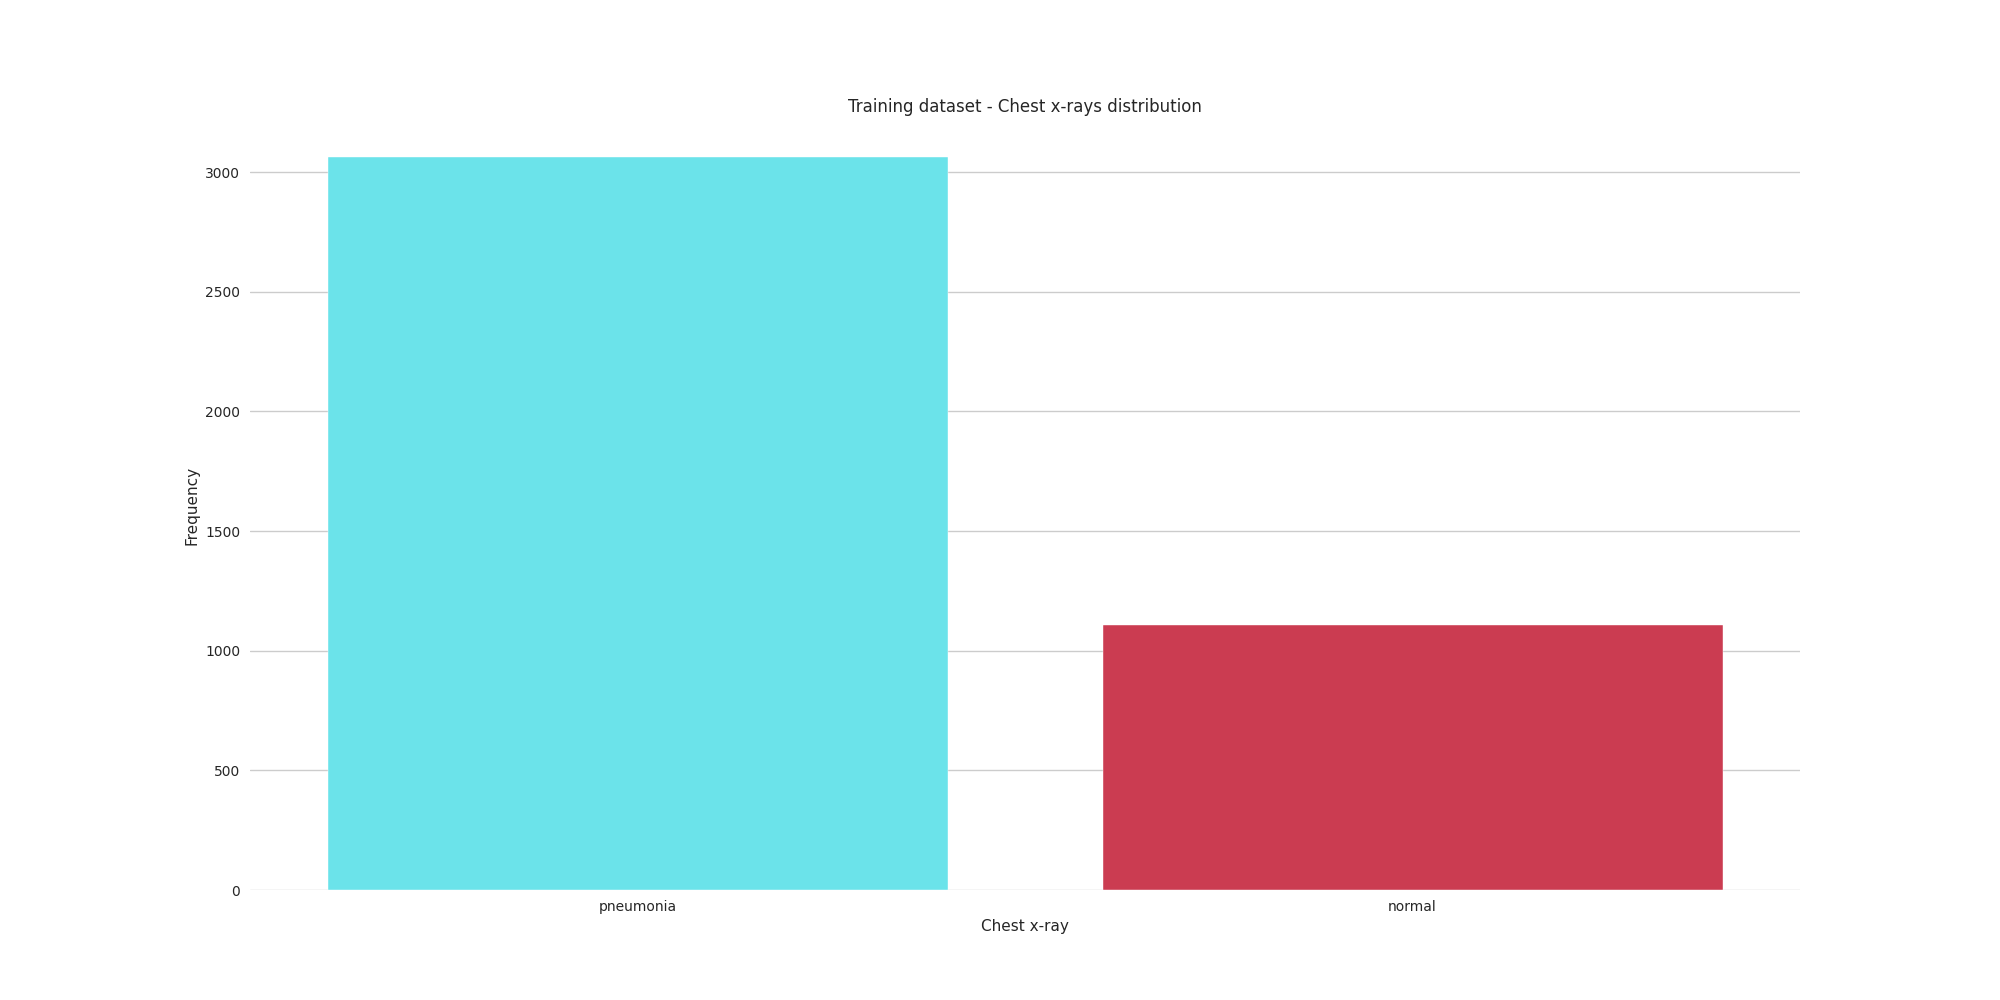

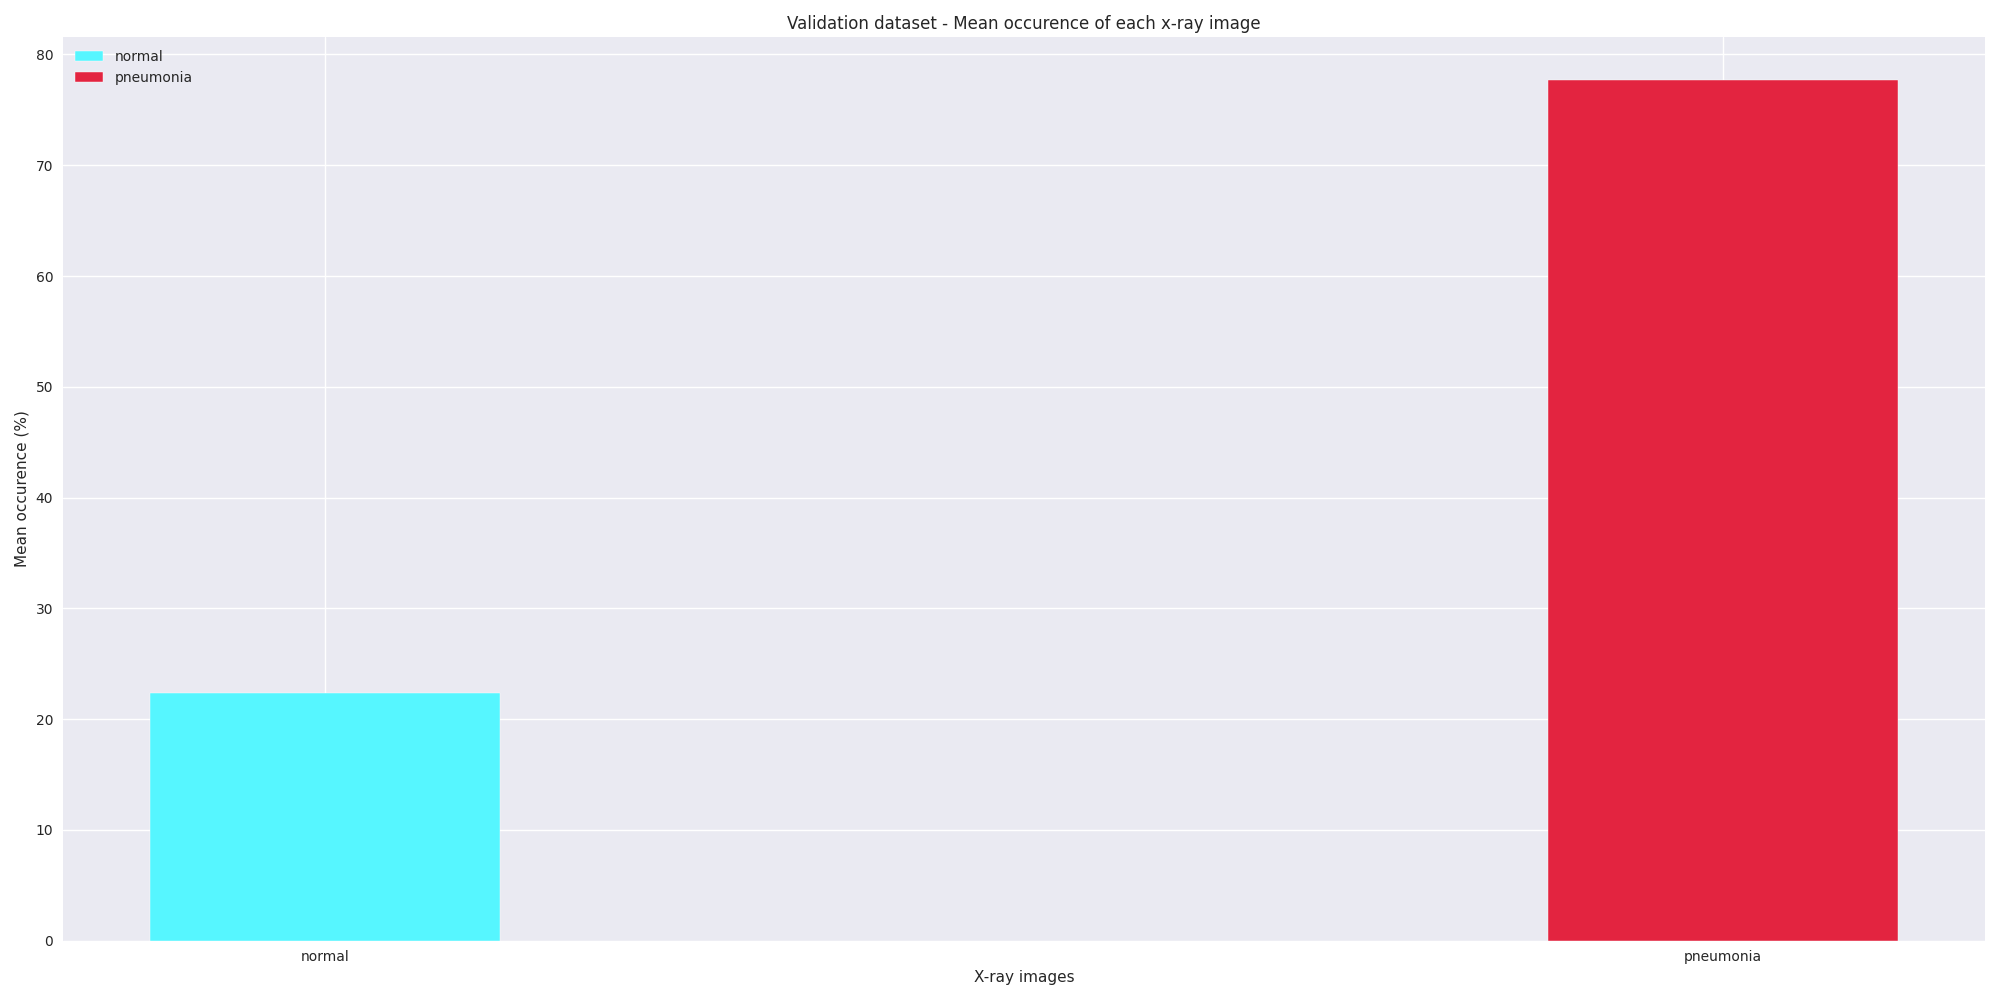
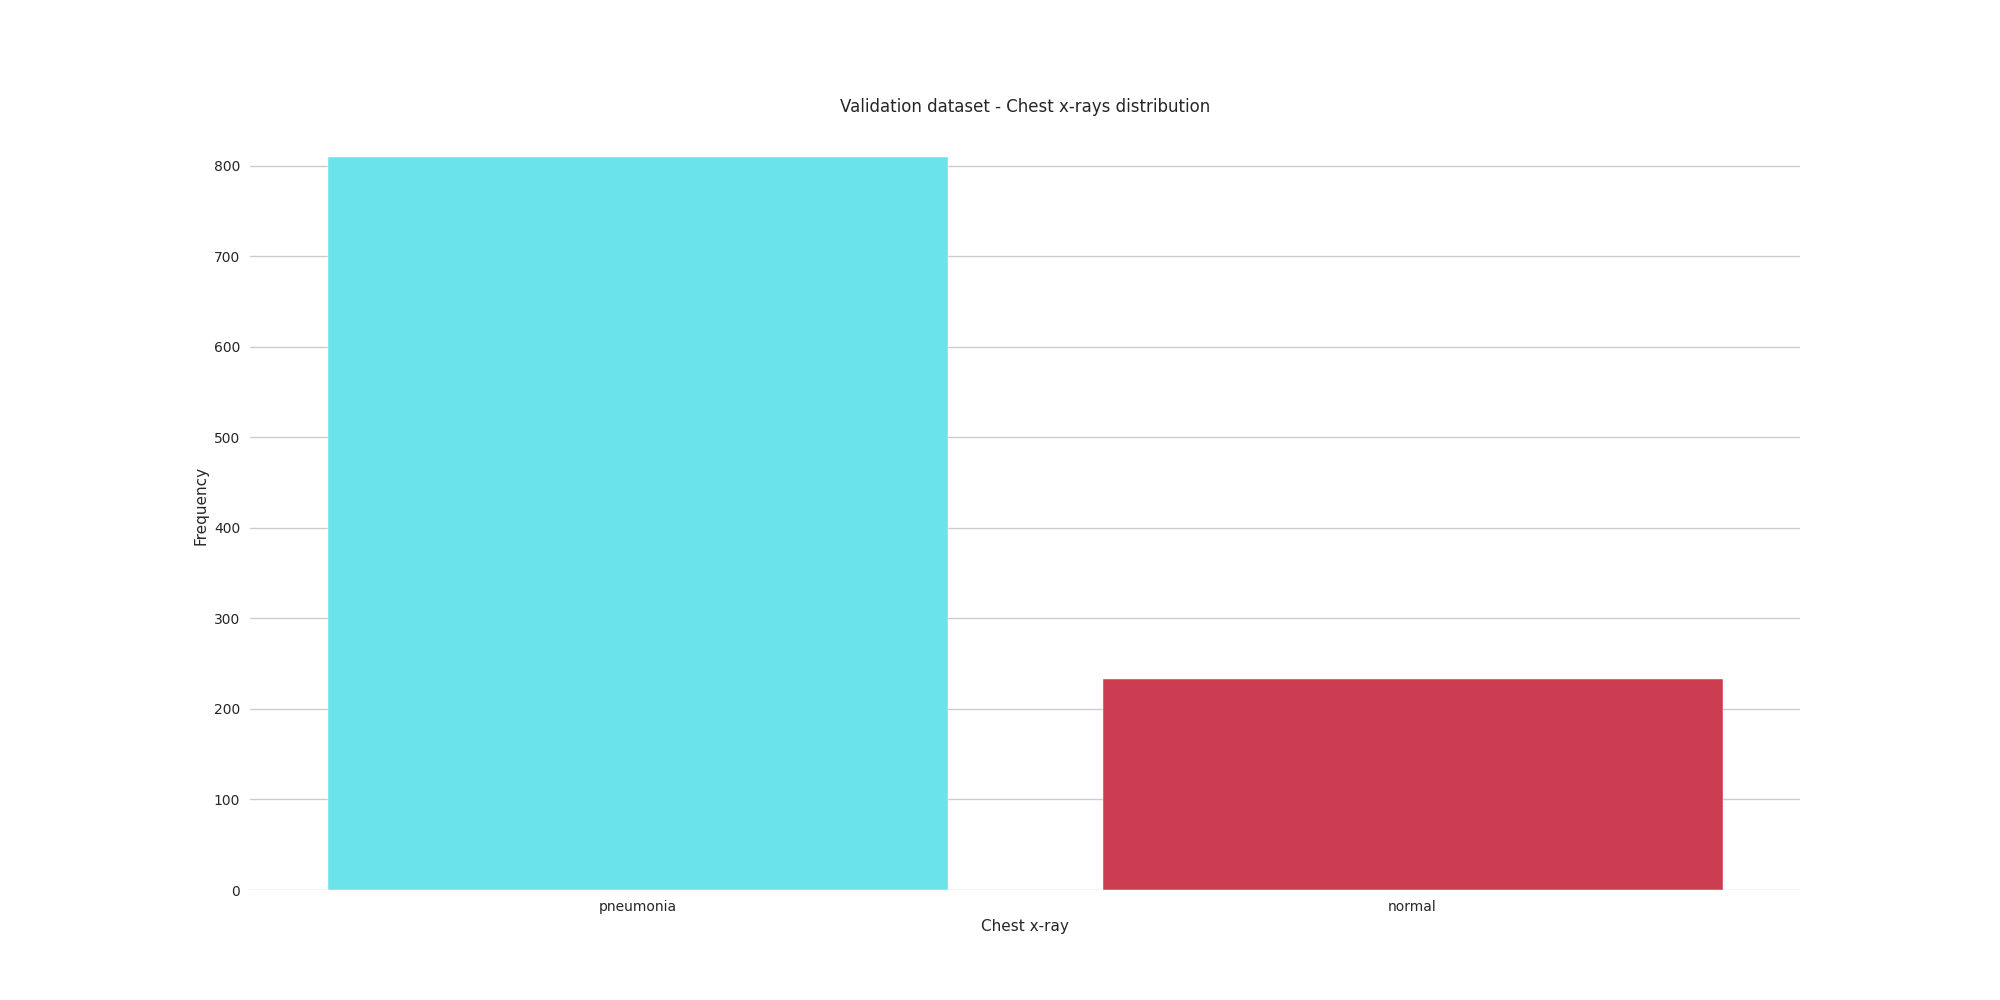

### Loss and accuracy after training

The two lines tend to convergein same direction. That's a good start but we can see that the line's curves aren't really smooth. 
Our model contains still a lot of variability. But we'll deal with that later too by adding some regularization technivs.

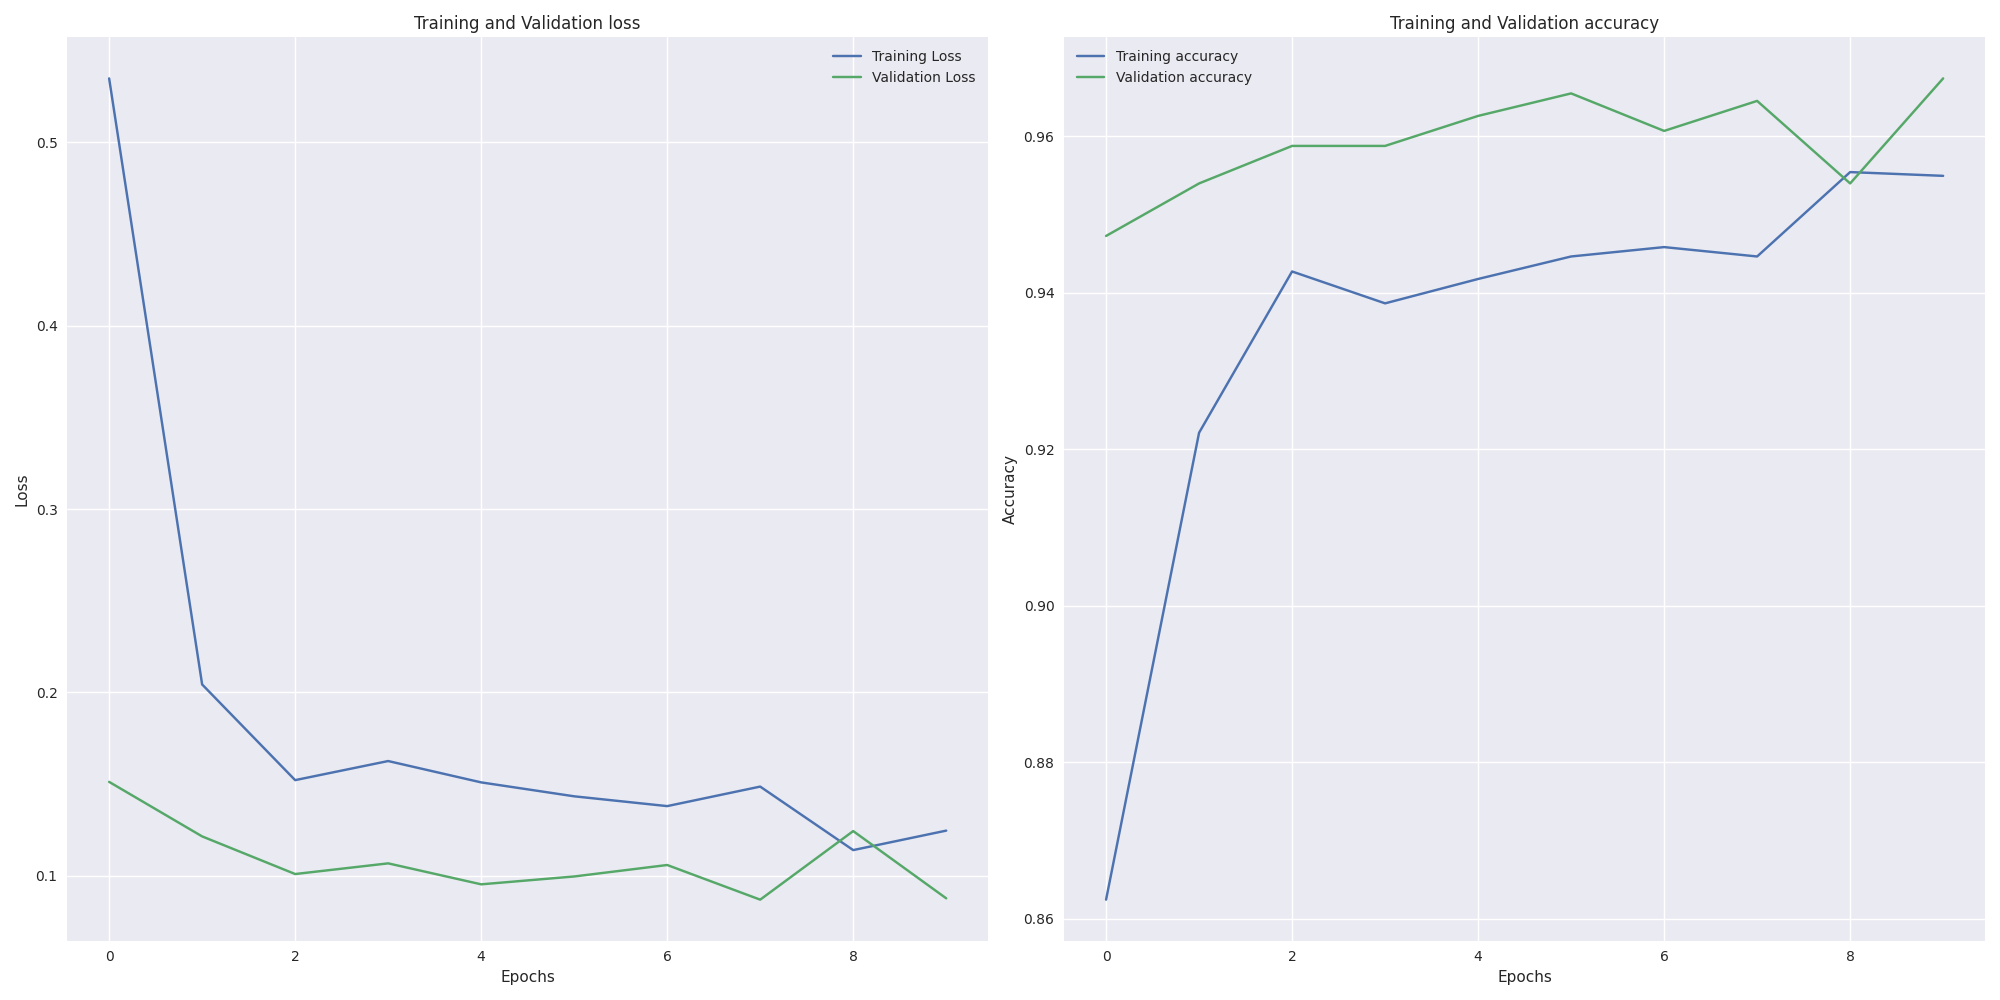

### Evaluation metrics

Here we're comparing the model to unseen data (test dataset). It's in this step that the real performances of the mdoel are revealed.

#### Confusion matrix

The confusion matrix allow us to see:
- Predictions guess as false and false
- Predictions guess as false but true
- Predictions guess as true and true
- Predictions guess as true but false

We can already see the results of the imbalency in the dataset. Among incorrect predictions ther is only 5 incorrect normal against 152 incorrect pneumonia.

This is tricky because the imbalancy can help us by limiting the false normal (so not identity as pnemonia) against the true one. In our case this is preferable.

In other hand, 152 false predictions is a too important proportion of incorrect predictions.

So we'll have to be carrefoul on this subject in next steps.

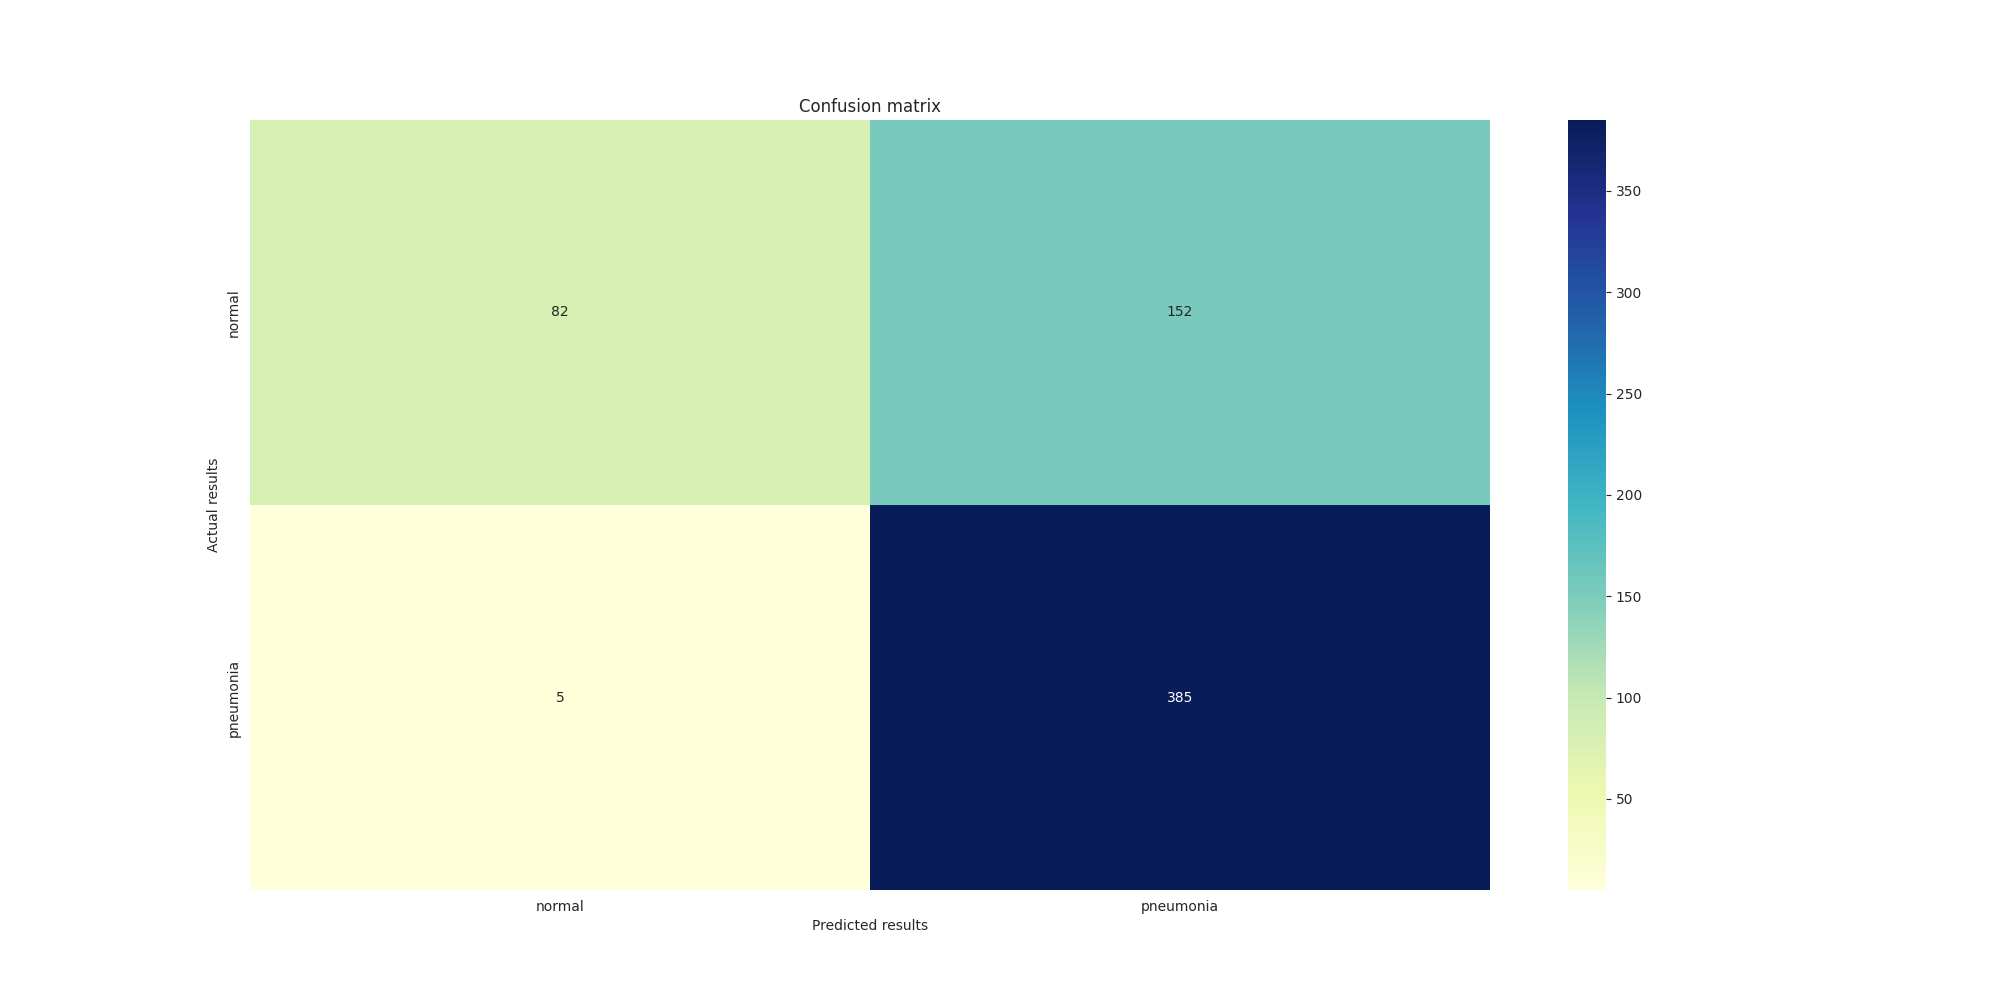


### ROC curve

This is a measure of the trade-off between true positive rate (sensitivity) and false positive rate (1-specificity) at various classification thresholds.

A higher ROC-AUC score indicates better classification performance, and it is more robust to class imbalance compared to accuracy.

So wee can see that our model isn't performing weel for now.

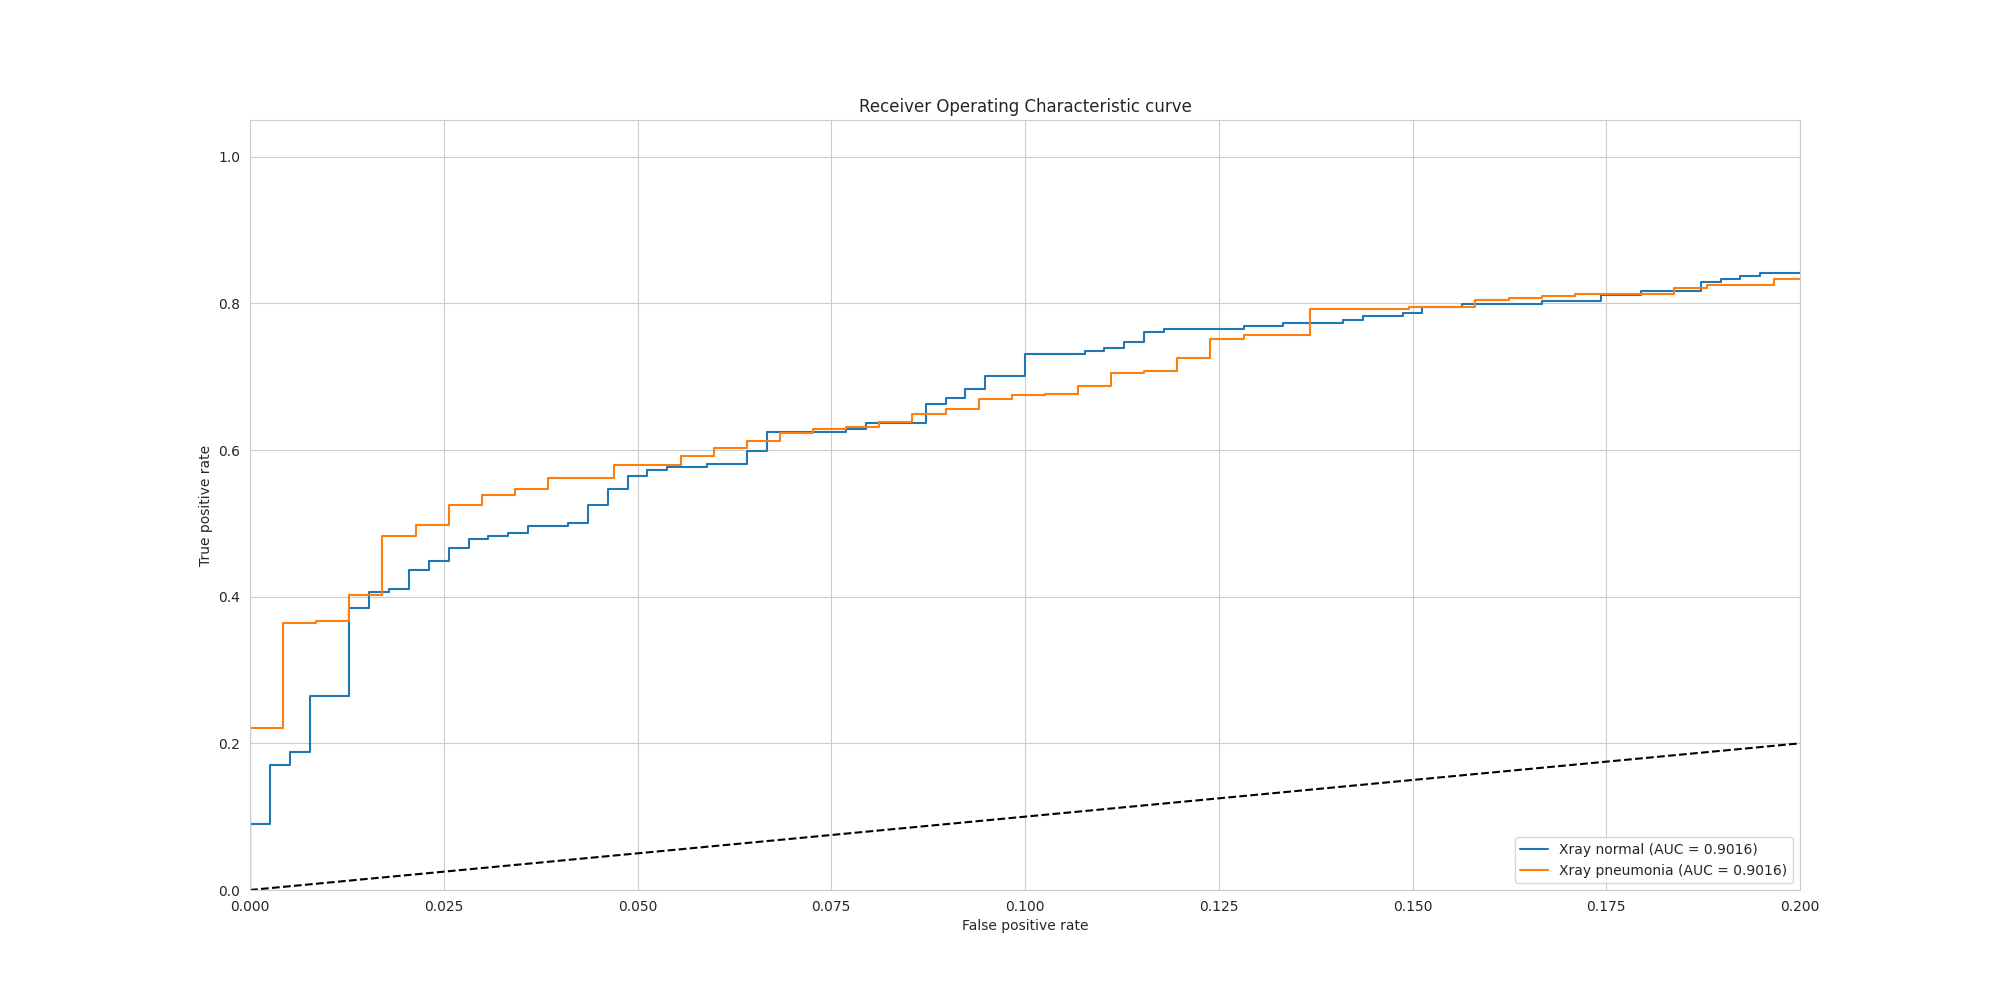

### Predictions examples

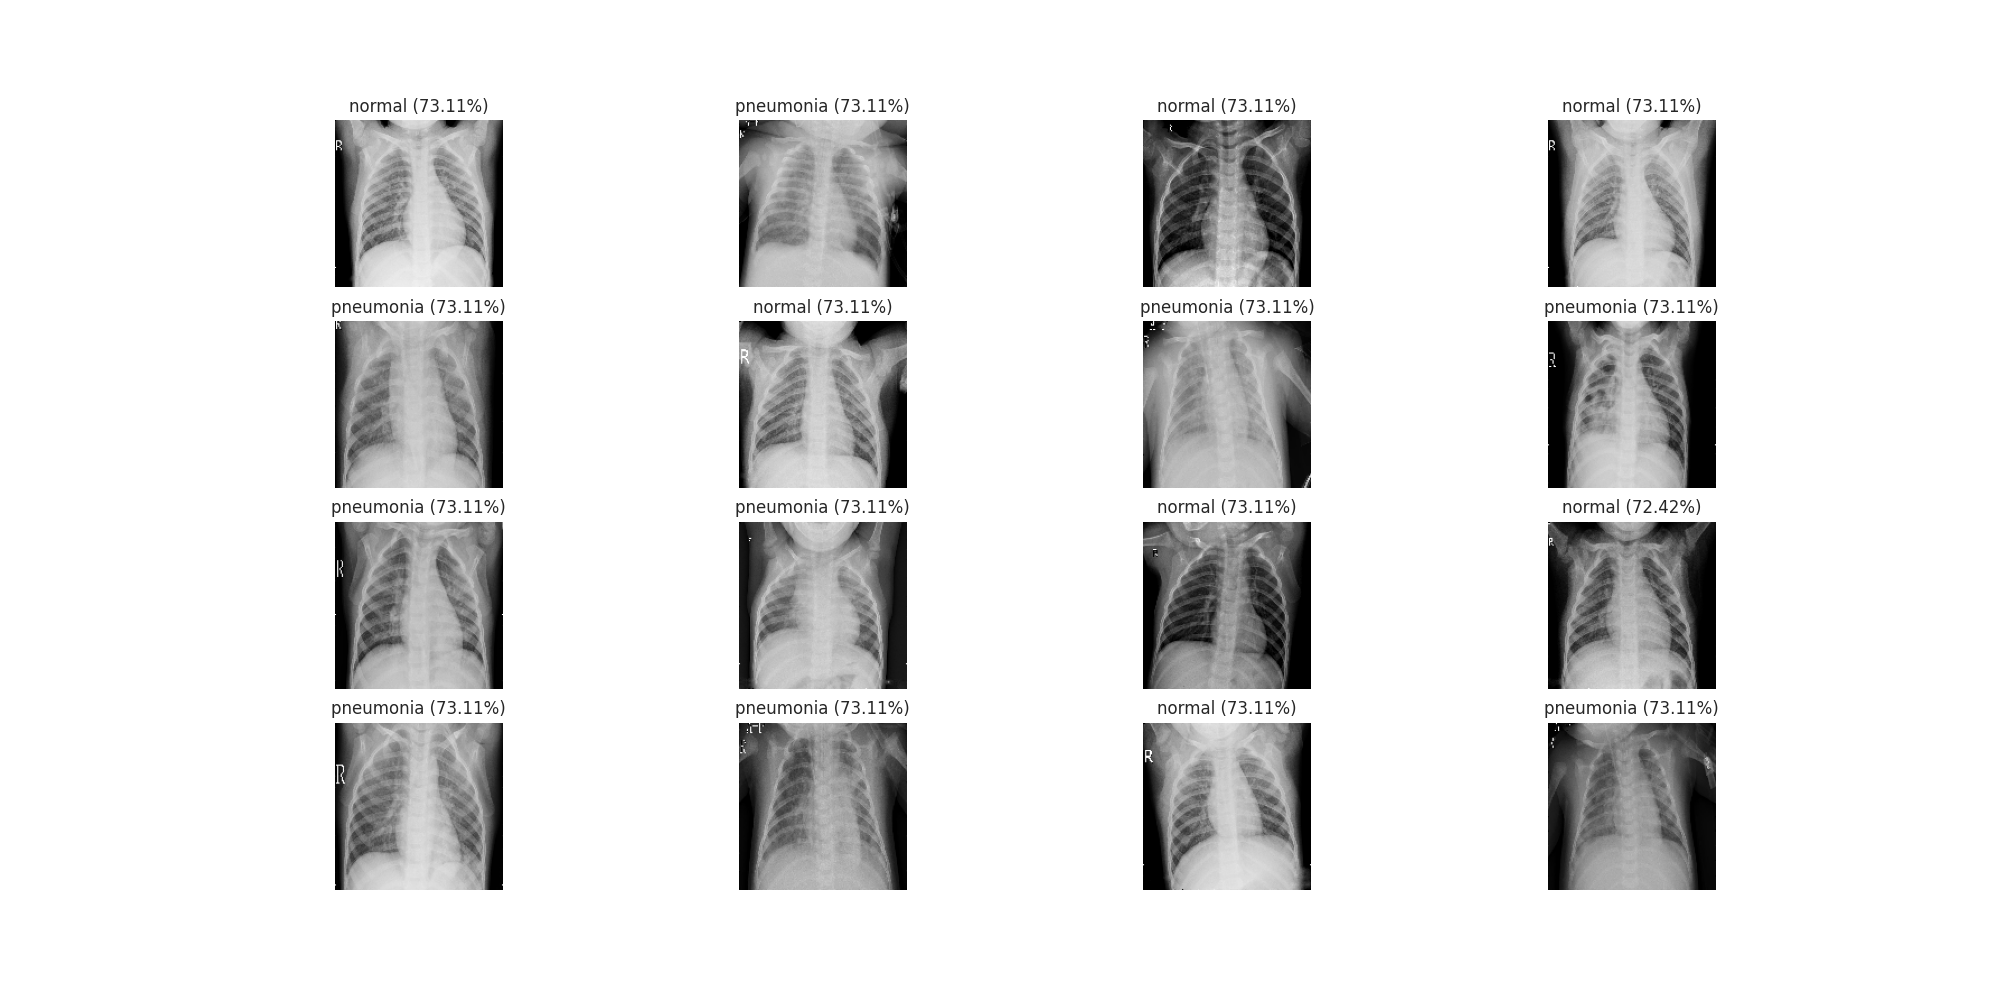
